# Use Case Description
**Server response time forecasting** involves predicting future server response times by analyzing historical data, identifying trends, and accounting for anticipated load changes. This proactive approach allows operations teams to anticipate potential performance degradation before it impacts users. By establishing dynamic thresholds on these forecasted values—for example, alerting if the predicted response time for the next hour is expected to exceed a critical latency threshold—organizations can receive early warnings of impending issues. This enables them to initiate capacity scaling, load balancing adjustments, or other mitigation strategies before actual response times breach unacceptable levels, thereby preventing service outages, maintaining Service Level Agreements (SLAs), and ensuring a consistent user experience.

# Dataset
The **../sample_data/server_responsetime.csv** dataset is used in this example, which is available under the data directory of this repo. The dataset contains 9,999 data points with 1-minute interval. It contains two fields: _time and rta (average response time). Recent data points have suggested an ascending trend in the server response time.

# Forecasting & Alerting
In this example, we use the Cisco Time Series Model to forecast the rta value of the **next 128 timestamps**, which adds up to about 2 hours into the future. Based on the **P90 quantile intervals** and **mean** forecasts, **alerts** are generated when the consecutive steps of breaching is forcasted.


# About this notebook
This notebook contains 5 stages to help users understand how to use the model:
* Stage 1: Import libraries and utilities
* Stage 2: Load the dataset and Visualize raw time series data
* Stage 3: Load the Cisco Time Series Model
* Stage 4: Visualization on the Multi-Resolution Processing
* Stage 5: Forecasting on Future States
* **Stage 6: Alerting based on forecasts**

---
# Stage 1: Import libraries and utilities

Libraries and functions for utilizing the model are imported in the cells below

In [1]:
import sys
from pathlib import Path

if "__file__" in globals():
    base_dir = Path(__file__).resolve().parent
else:
    base_dir = Path.cwd()

parent = base_dir.parent
if str(parent) not in sys.path:
	sys.path.insert(0, str(parent))
    
import pandas as pd
import torch
import matplotlib.pyplot as plt

from modeling import CiscoTsmMR, TimesFmHparams, TimesFmCheckpoint

 See https://github.com/google-research/timesfm/blob/master/README.md for updated APIs.
Loaded PyTorch TimesFM, likely because python version is 3.11.10 | packaged by conda-forge | (main, Oct 16 2024, 01:27:36) [GCC 13.3.0].


---
# Stage 2: Load the dataset and Visualize raw time series data

Read dataset from the data/ path and visualize the raw input time series

In [2]:
with open("../sample_data/server_responsetime.csv", 'r') as f:
    df = pd.read_csv(f)
df = df.set_index('_time')
df

,rta
_time,
2015-02-18T14:17:26.000-0800,1.056
2015-02-18T14:18:27.000-0800,1.128
2015-02-18T14:19:28.000-0800,1.088
2015-02-18T14:20:34.000-0800,1.088
2015-02-18T14:21:35.000-0800,1.773
...,...
2015-02-25T16:41:10.000-0800,5.700
2015-02-25T16:42:12.000-0800,5.500
2015-02-25T16:43:14.000-0800,6.700


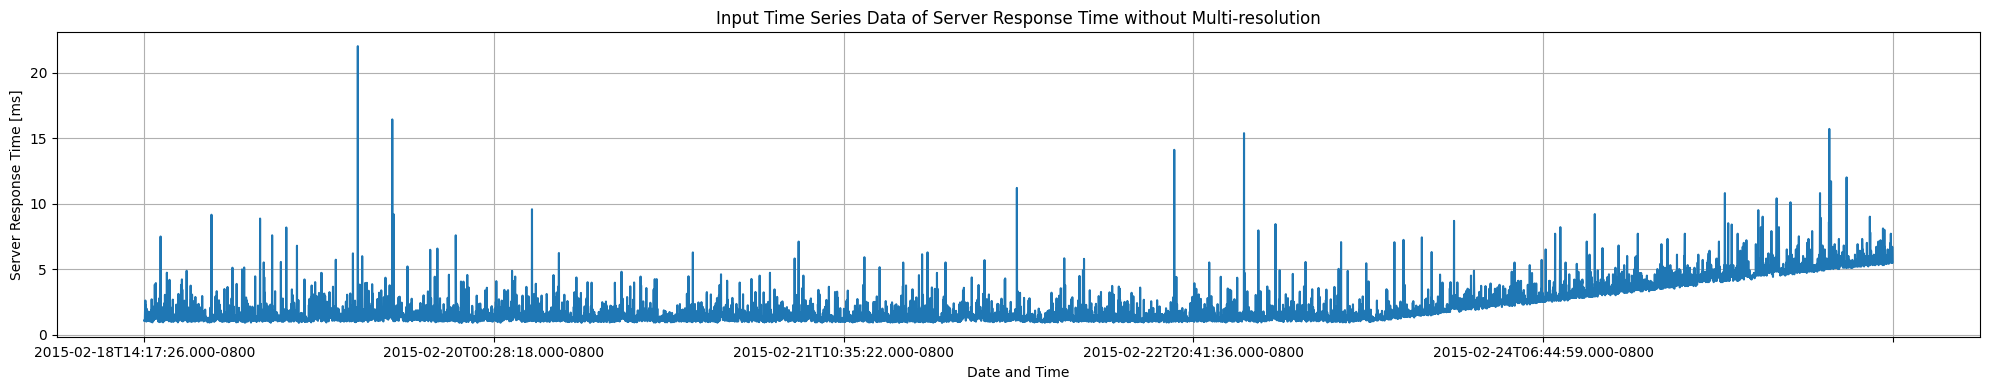

In [3]:
plt.figure(figsize=(20, 4))
df['rta'].plot(title='Input Time Series Data of Server Response Time without Multi-resolution', grid=True)
plt.xlabel('Date and Time')
plt.ylabel('Server Response Time [ms]')
plt.grid(True)
plt.tight_layout() 
plt.show()

---
# Stage 3: Load the Cisco Time Series Model

Download the model checkpoint from Huggingface.

In [4]:
hp = TimesFmHparams(
	num_layers=50,
	use_positional_embedding=False,
	backend="gpu" if torch.cuda.is_available() else "cpu",
)

# Load model from the Huggingface repo of Cisco Time Series Model
repo_id = "cisco-ai/cisco-time-series-model-1.0-preview"

ckpt = TimesFmCheckpoint(huggingface_repo_id=repo_id)

model = CiscoTsmMR(
    hparams=hp,
    checkpoint=ckpt,
    use_resolution_embeddings=True,
    use_special_token=True,
)

Fetching 7 files:   0%|          | 0/7 [00:00<?, ?it/s]

---
# [OPTIONAL] Stage 4: Visualization on the Multi-Resolution Processing 

* The cell below visualizes how multi-resolution processing transforms the input time series, This cell is **ONLY for showcasing purpose**. 
* During inference, the multi-reposution transformation happens automatically.

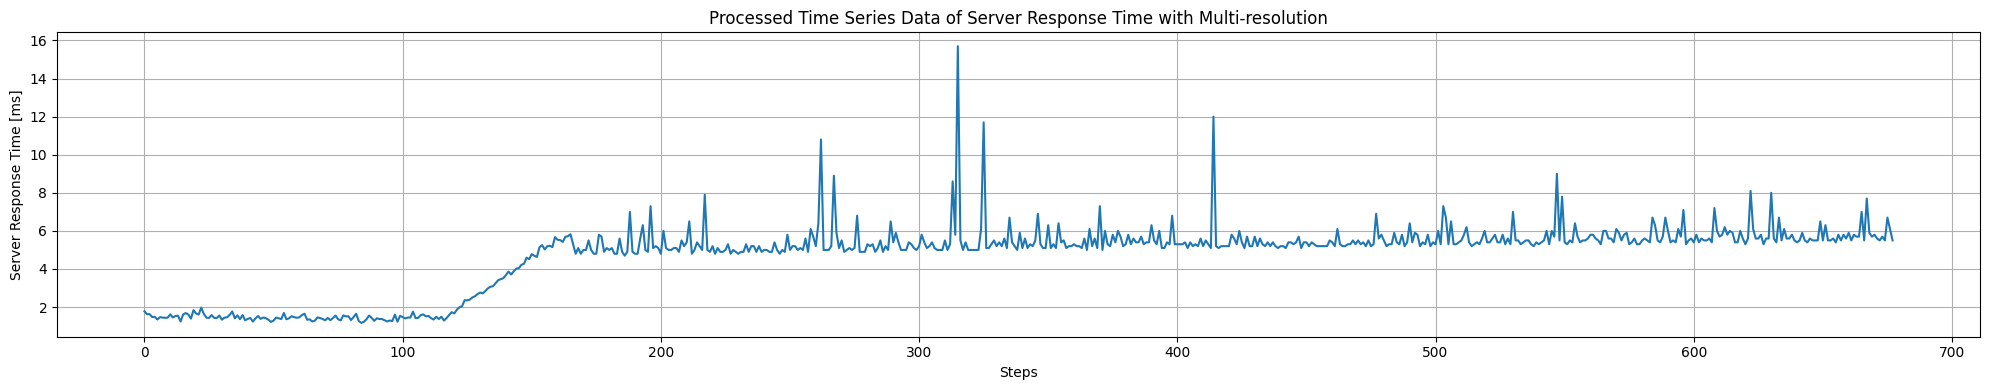

In [5]:
context_1hr, context_1min = model.build_multi_resolution(df["rta"].tolist())
processed_series = context_1hr
processed_series.extend(context_1min)
plt.figure(figsize=(20, 4))
plt.plot(list(range(len(processed_series))), processed_series, linestyle='-', markersize=4)
plt.title('Processed Time Series Data of Server Response Time with Multi-resolution')
plt.xlabel('Steps')
plt.ylabel('Server Response Time [ms]')
plt.grid(True)
plt.tight_layout()
plt.show()

---
# Stage 5: Forecasting on Future States

To forecast the future states, we use the model to forecast the next 128 steps into the future.

In [6]:
future_forecasts = model.forecast([df["rta"].tolist()], horizon_len=128)

/home/ubuntu/praneet/github/cisco-time-series-model/1.0-preview/modeling/cisco_tsm_mr.py:373: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  batch_coarse = torch.as_tensor(coarse_contexts[start:end],  dtype=torch.float32).unsqueeze(-1).to(self._device)


In [7]:
print("Mean: " + str(future_forecasts[0]["mean"].shape))
print("Quantile 0.1: " + str(future_forecasts[0]["quantiles"]["0.1"].shape))

Mean: (128,)
Quantile 0.1: (128,)


In [8]:
# Padding Ground-truth series
ground_truth_future = processed_series.copy()
ground_truth_future.extend(["N/A"]*128)

# Obtain mean and quantiles of the forecasted series
means_future = processed_series + future_forecasts[0]["mean"].tolist()
p10_future = processed_series + future_forecasts[0]["quantiles"]["0.1"].tolist() 
p20_future = processed_series + future_forecasts[0]["quantiles"]["0.2"].tolist() 
p30_future = processed_series + future_forecasts[0]["quantiles"]["0.3"].tolist() 
p40_future = processed_series + future_forecasts[0]["quantiles"]["0.4"].tolist() 
p50_future = processed_series + future_forecasts[0]["quantiles"]["0.5"].tolist() 
p60_future = processed_series + future_forecasts[0]["quantiles"]["0.6"].tolist() 
p70_future = processed_series + future_forecasts[0]["quantiles"]["0.7"].tolist() 
p80_future = processed_series + future_forecasts[0]["quantiles"]["0.8"].tolist() 
p90_future = processed_series + future_forecasts[0]["quantiles"]["0.9"].tolist() 

# Put all results into a dataframe
df_plot_future = pd.DataFrame({
    'Steps': list(range(len(ground_truth_future))),
    'Ground_Truth': ground_truth_future,
    'TSFM_Mean': means_future,
    'TSFM_P10': p10_future,
    'TSFM_P20': p20_future,
    'TSFM_P30': p30_future,
    'TSFM_P40': p40_future,
    'TSFM_P50': p50_future,
    'TSFM_P60': p60_future,
    'TSFM_P70': p70_future,
    'TSFM_P80': p80_future,
    'TSFM_P90': p90_future,
})

df_plot_future.set_index('Steps')

,Ground_Truth,TSFM_Mean,TSFM_P10,TSFM_P20,TSFM_P30,TSFM_P40,TSFM_P50,TSFM_P60,TSFM_P70,TSFM_P80,TSFM_P90
Steps,,,,,,,,,,,
0,1.7794,1.779400,1.779400,1.779400,1.779400,1.779400,1.779400,1.779400,1.779400,1.779400,1.779400
1,1.628283,1.628283,1.628283,1.628283,1.628283,1.628283,1.628283,1.628283,1.628283,1.628283,1.628283
2,1.63105,1.631050,1.631050,1.631050,1.631050,1.631050,1.631050,1.631050,1.631050,1.631050,1.631050
3,1.47945,1.479450,1.479450,1.479450,1.479450,1.479450,1.479450,1.479450,1.479450,1.479450,1.479450
4,1.4896,1.489600,1.489600,1.489600,1.489600,1.489600,1.489600,1.489600,1.489600,1.489600,1.489600
...,...,...,...,...,...,...,...,...,...,...,...
801,N/A,6.134682,5.628165,5.733835,5.800258,5.870239,5.949324,6.039892,6.171906,6.402161,6.995035
802,N/A,6.140784,5.629736,5.735686,5.803595,5.872436,5.948866,6.044935,6.171175,6.404024,6.989505
803,N/A,6.131998,5.645106,5.737957,5.799003,5.861660,5.931467,6.019966,6.149218,6.371803,6.950392


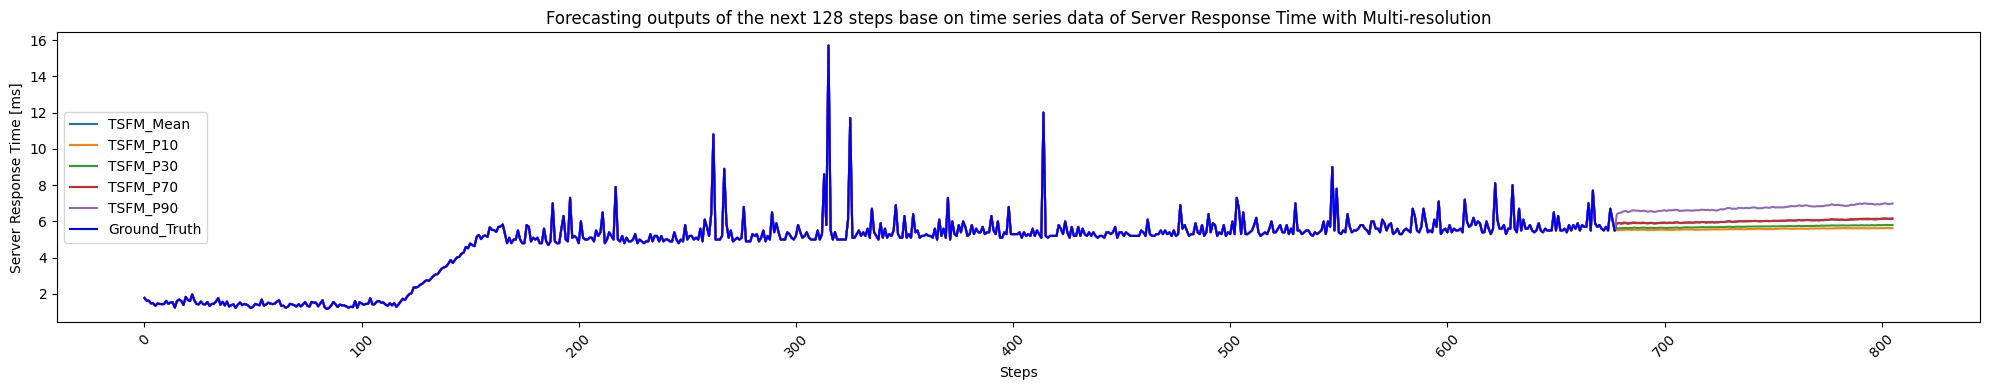

In [9]:
# Select columns to plot
df_plot_future_final = df_plot_future[['TSFM_Mean', 'TSFM_P10', 'TSFM_P30', 'TSFM_P70', 'TSFM_P90']]
plt.figure(figsize=(20, 4)) 
ax = df_plot_future_final.plot(ax=plt.gca(), title='Forecasting outputs of the next 128 steps base on time series data of Server Response Time with Multi-resolution', grid=True)
# Add the plot of ground truth on the top
df_plot_future['Ground_Truth'][:-128].plot(ax=ax, color='blue', label='Ground_Truth')
plt.xlabel('Steps')
plt.ylabel('Server Response Time [ms]')
ax.legend(title='Data Series')
ax.legend(loc='center left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

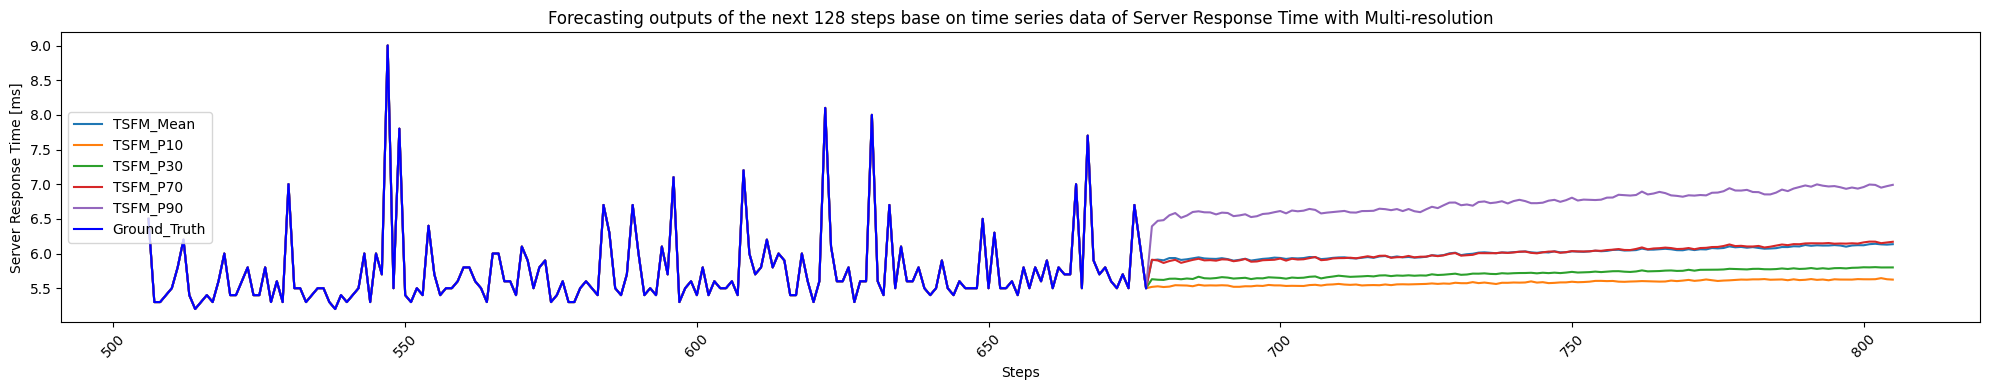

In [10]:
# Zoom-in Plot
df_plot_future_final = df_plot_future[['TSFM_Mean', 'TSFM_P10', 'TSFM_P30', 'TSFM_P70', 'TSFM_P90']][-300:]
plt.figure(figsize=(20, 4)) 
ax = df_plot_future_final.plot(ax=plt.gca(), title='Forecasting outputs of the next 128 steps base on time series data of Server Response Time with Multi-resolution', grid=True)
# Add the plot of ground truth on the top
df_plot_future['Ground_Truth'][-300:][:-128].plot(ax=ax, color='blue', label='Ground_Truth')
plt.xlabel('Steps')
plt.ylabel('Server Response Time [ms]')
ax.legend(title='Data Series')
ax.legend(loc='center left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

---
# Stage 6: Alerting based on forecasts

In [11]:
import datetime
# Set alerting threshold 
THRESHOLD_P90 = 6.5
THRESHOLD_mean = 6.0
# Set alerting consecutive steps. i.e., genenrate alert only if the forecast value exceeds threshold for how many consecutive steps 
CONSECUTIVE_STEPS_P90 = 5
CONSECUTIVE_STEPS_mean = 10

# Current TIme
current_time = df.index[-1]
parse_format = "%Y-%m-%dT%H:%M:%S.%f%z"
dt_object = datetime.datetime.strptime(current_time, parse_format)
print(("#" * 80))
print("\n[INFORMATION]:\n")
print(f"Current Time: {current_time}")
print("-" * 80)


def check_consecutive_forecast_exceedance(forecast_values, threshold, consecutive_steps_required):
    if not forecast_values or len(forecast_values) < consecutive_steps_required:
        return False

    consecutive_count = 0
    start_index_of_consecutive_exceedance = None

    for i, value in enumerate(forecast_values):
        if value > threshold:
            if consecutive_count == 0: 
                start_index_of_consecutive_exceedance = i
            consecutive_count += 1
            if consecutive_count >= consecutive_steps_required:
                return start_index_of_consecutive_exceedance + 1
        else:
            consecutive_count = 0
            start_index_of_consecutive_exceedance = None
    return False


primary_alert = check_consecutive_forecast_exceedance(future_forecasts[0]["quantiles"]["0.9"].tolist(), THRESHOLD_P90, CONSECUTIVE_STEPS_P90)
secondary_alert = check_consecutive_forecast_exceedance(future_forecasts[0]["mean"].tolist(), THRESHOLD_mean, CONSECUTIVE_STEPS_mean)

if primary_alert:
    print("#" * 80)
    print("\n[WARNING]:\n")
    print(f"P90 forecast on Server Response Time exceeding threshold {THRESHOLD_P90} for {CONSECUTIVE_STEPS_P90} consecutive steps detected in {primary_alert} minutes \n")
    time_delta = datetime.timedelta(minutes=primary_alert)
    new_dt_object = dt_object + time_delta
    milliseconds_part = f"{new_dt_object.microsecond // 1000:03d}"
    primary_timestamp = new_dt_object.strftime(f"%Y-%m-%dT%H:%M:%S.{milliseconds_part}%z")
    print(f"Forcasted Alert Time: {primary_timestamp}\n")
    print(f"Forcasted Server Response Time [ms]: {future_forecasts[0]['quantiles']['0.9'].tolist()[primary_alert-1]}\n")
    print("-" * 80)

if secondary_alert:
    print("#" * 80)
    print("\n[CRITICAL]:\n")
    print(f"Mean forecast on Server Response Time exceeding threshold {THRESHOLD_mean} for {CONSECUTIVE_STEPS_mean} consecutive steps detected in {secondary_alert} minutes \n")
    time_delta = datetime.timedelta(minutes=secondary_alert)
    new_dt_object = dt_object + time_delta
    milliseconds_part = f"{new_dt_object.microsecond // 1000:03d}"
    secondary_timestamp = new_dt_object.strftime(f"%Y-%m-%dT%H:%M:%S.{milliseconds_part}%z")
    print(f"Forcasted Alert Time: {secondary_timestamp}\n")
    print(f"Forcasted Server Response Time [ms]: {future_forecasts[0]['mean'].tolist()[secondary_alert-1]}\n")
    print("-" * 80)




################################################################################

[INFORMATION]:

Current Time: 2015-02-25T16:45:17.000-0800
--------------------------------------------------------------------------------
################################################################################

[WARNING]:

P90 forecast on Server Response Time exceeding threshold 6.5 for 5 consecutive steps detected in 4 minutes 

Forcasted Alert Time: 2015-02-25T16:49:17.000-0800

Forcasted Server Response Time [ms]: 6.551921367645264

--------------------------------------------------------------------------------
################################################################################

[CRITICAL]:

Mean forecast on Server Response Time exceeding threshold 6.0 for 10 consecutive steps detected in 57 minutes 

Forcasted Alert Time: 2015-02-25T17:42:17.000-0800

Forcasted Server Response Time [ms]: 6.013134002685547

-----------------------------------------------------------------------